In [1]:
import torch, os
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision.datasets.utils import check_integrity
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from masked_celeba import CelebA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# access celebA
data_root = 'data'
# Spatial size of training images, images are resized to this size.
image_size = 64

celeba_train = CelebA(data_root,
                              download=False,
                              split = "train",
                              transform=transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                       std=[0.5, 0.5, 0.5])
                              ]),
                              proportion = 0.3)

celeba_test = CelebA(data_root,
                              download=False,
                              split = "test",
                              transform=transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                       std=[0.5, 0.5, 0.5])
                              ]),
                              proportion = 0.3) 

In [12]:
# Create training and test dataloaders

num_workers = 4
# how many samples per batch to load
batch_size = 2

# prepare data loaders
train_loader = torch.utils.data.DataLoader(celeba_train, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(celeba_test, batch_size=batch_size, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

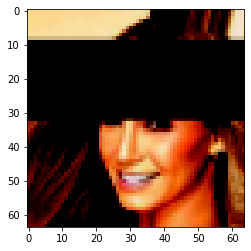

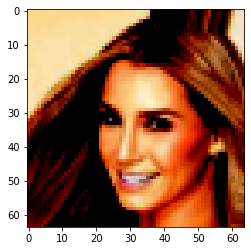

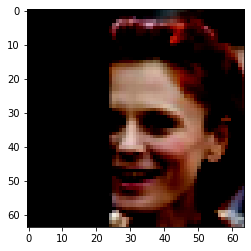

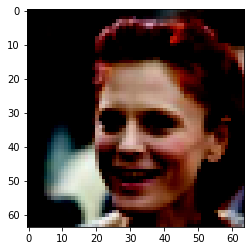

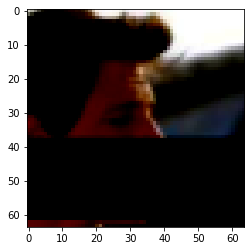

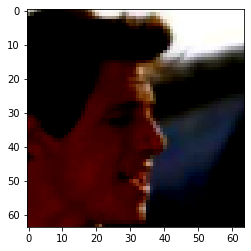

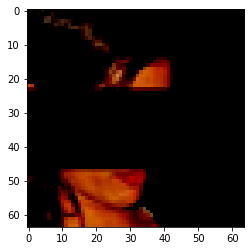

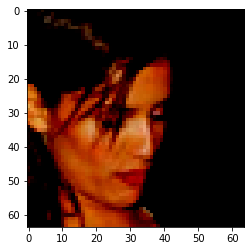

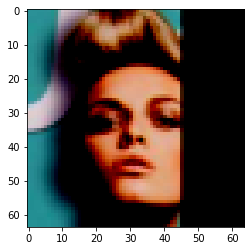

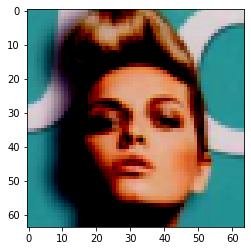

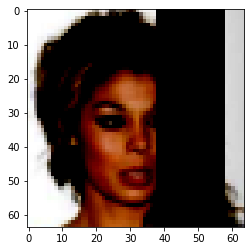

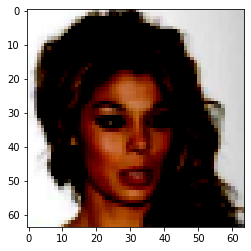

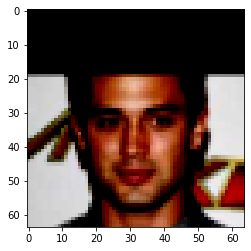

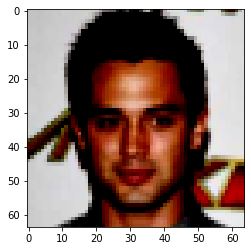

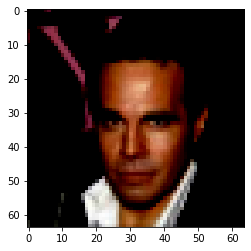

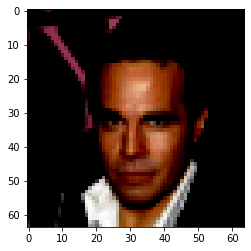

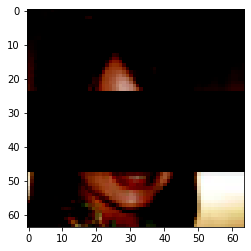

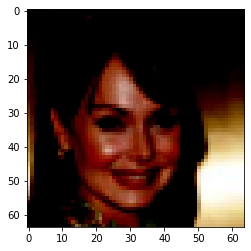

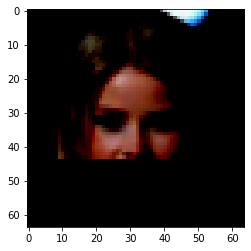

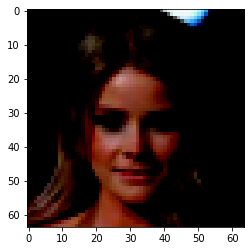

In [6]:
count = 0
for elem in celeba_train:
    for e in elem:
        plt.figure()
        plt.imshow(e.detach().permute(1, 2, 0).numpy())
    count += 1
    if count == 10:
        break

In [7]:
def dice_coef(y_true, y_pred):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (torch.sum(y_true_f + y_pred_f))


In [8]:
class VanillaAE(nn.Module):
    
    def __init__(self):
        super(VanillaAE, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

        
    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))
        
        return x

In [9]:
model = VanillaAE()


In [10]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: comppute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: -88.077168
Epoch: 2 	Training Loss: -94.560454


KeyboardInterrupt: 

2


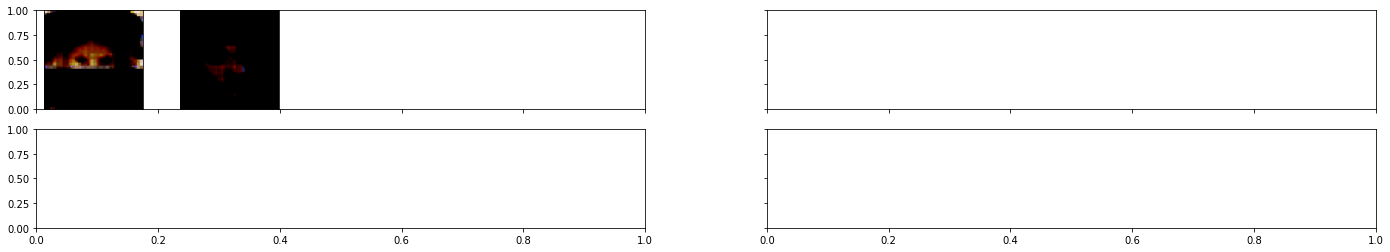

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
print(len(output))
# prep images for display
images = images.numpy()


# output is resized into a batch of iages
output = output.view(batch_size, 3, 64, 64)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))

# # input images on top row, reconstructions on bottom
# for images, row in zip([images, output], axes):
#     for img, ax in zip(images, row):
#         ax.imshow(np.squeeze(img))
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=batch_size, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(output[idx].transpose(1, 2, 0))
    
# # plot the first ten input images and then reconstructed images
# fig, axes = plt.subplots(nrows=2, ncols=batch_size, sharex=True, sharey=True, figsize=(24,4))
# for idx in np.arange(batch_size):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     plt.imshow(images[idx].transpose(1, 2, 0))
